# Goal:  Enable intuative and efficient querying over multiple parquet file outputs 

## Using `DuckDB`:
- no dependencies; just `pip install duckdb` and you are ready
- data is read in streaming fashion to prevent memory issues (no initial loading required)
- processes multiple files in parallel using glob syntax
- only the desired columns are read
- SQL API to make interviewing the data intuative
- feature rich

## Resources:
- Parquet files with DuckDB:  https://duckdb.org/docs/data/parquet
- More Parquet with DuckDB:  https://duckdb.org/2021/06/25/querying-parquet.html
- SQL with DuckDB:  https://duckdb.org/docs/sql/introduction
- SQL aggregate functions in DuckDB:  https://duckdb.org/docs/sql/aggregates



In [2]:
import os
import glob

import duckdb
import pandas as pd
import seaborn as sns


## Data description

Antonia's data is structured in the following way:

- `S<sample>_<realization>/S<sample>_<realization>_<demand_rule>.parquet`

- There are a total of **600,000 files**.  Each file is compressed to **~500 KB**, has **432,180 records** has the following columns: `'structure_id', 'year', 'month', 'demand', 'shortage', 'sample', 'realization', 'demand rule'`

- This results in a total of **259,308,000,000 records** that compress to **~300 GB**.

- Both demand and shortage are provided for **343 users** (`structure_id`) which are evaluated per sample, hydrologic realization, adaptive rule, year, and month per file.

- There are a total of **100 samples**, **1,000 hydrologic realizations**, **600 adaptive rules**, **343 users**, **105 years (1908-2013)**, and **12 months**.

**NOTES**:
- date range is in water year therefore year 1908 has only three months reported (OCT, NOV, DEC) and 2013 only has 9 (JAN-SEP)
- beware of the `demand rule` column name, use `"demand rule" AS demand_rule` to correctly reference column names with spaces




## Setup inquiry

The data in the `xdd_parquet` directory was downloaded from the CUBE here:  `/scratch/ah986/adaptive_demands_experiment/xdd_parquet`

In [8]:
# directory the data was downloaded to locally
data_dir = '/Users/d3y010/projects/antonia/data/xdd_parquet'


### Select multiple files of the same schema using glob syntax

| Wildcard | Description |
| -------- | ----------- |
| * | matches any number of any characters (including none) |
| ? | matches any single character |
| [abc] | matches one character given in the bracket |
| [a-z] | matches one character from the range given in the bracket |


In [9]:
# target glob path
glob_path = os.path.join(data_dir, 'S[1-2]_[1-2]/S*_*_[0-1].parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 432180  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))


Exploring 3,457,440 records over 8 files.


## Sample Structured Query Language (SQL) statements

#### I want to preview the data.  Let's just look at the first 10 rows for all columns.

In [11]:
%%time

sql = f"""
SELECT
    *
FROM
    '{glob_path}'  
LIMIT 10;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

df


CPU times: user 14.1 ms, sys: 61.7 ms, total: 75.8 ms
Wall time: 75.9 ms


,structure_id,year,month,demand,shortage,sample,realization,demand rule
0,5100848,1908,OCT,130,0,2,1,0
1,5100848,1908,NOV,0,0,2,1,0
2,5100848,1908,DEC,0,0,2,1,0
3,5100848,1909,JAN,0,0,2,1,0
4,5100848,1909,FEB,0,0,2,1,0
5,5100848,1909,MAR,0,0,2,1,0
6,5100848,1909,APR,64,0,2,1,0
7,5100848,1909,MAY,1787,0,2,1,0
8,5100848,1909,JUN,5135,0,2,1,0
9,5100848,1909,JUL,4684,0,2,1,0


#### I would like to see all rows where demand was greater than 5000 for the user (`structure_id`) '5100848' only for years 1908 and 2013.

In [18]:
%%time

sql = f"""
SELECT
    *
FROM
    '{glob_path}' 
WHERE
    structure_id = '5100848'
    AND (year = 1908 OR year = 2013)
    AND demand > 5000;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

df


CPU times: user 148 ms, sys: 63.8 ms, total: 211 ms
Wall time: 212 ms


,structure_id,year,month,demand,shortage,sample,realization,demand rule
0,5100848,2013,JUN,6519,0,2,1,0
1,5100848,2013,JUN,6519,0,2,1,1
2,5100848,2013,JUN,6348,0,1,1,1
3,5100848,2013,JUN,6348,0,1,1,0
4,5100848,2013,JUN,6464,0,2,2,0
5,5100848,2013,JUN,6464,0,2,2,1
6,5100848,2013,JUN,6263,0,1,2,1
7,5100848,2013,JUN,6263,0,1,2,0


#### What is the average demand per year and realization for years > 2010?

In [19]:
%%time

sql = f"""
SELECT
    year
    ,realization
    ,AVG(demand) AS avg_demand
FROM
    '{glob_path}'  
GROUP BY
    year
    ,realization
HAVING
    year > 2010;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

df


CPU times: user 82.5 ms, sys: 60.7 ms, total: 143 ms
Wall time: 143 ms


,year,realization,avg_demand
0,2011,1,768.869534
1,2012,1,816.642493
2,2013,1,870.505183
3,2011,2,767.512148
4,2012,2,815.530491
5,2013,2,869.390833


#### What are the min, max, average, median, kutosis, skewness,and approximate 90% quantile for each year and month for years 2000-2010?

Lots more options here:  https://duckdb.org/docs/sql/aggregates

In [20]:
%%time

sql = f"""
SELECT
    year
    ,month
    ,MIN(demand) AS min_demand
    ,MAX(demand) AS max_demand
    ,AVG(demand) AS avg_demand
    ,MEDIAN(demand) AS median_demand
    ,kurtosis(demand) AS kurtosis_demand
    ,skewness(demand) AS skewness_demand
    ,approx_quantile(demand, 0.9) AS quantile_0p9_demand
FROM
    '{glob_path}'
GROUP BY
    year
    ,month
HAVING
    year BETWEEN 2000 AND 2010;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

df


CPU times: user 146 ms, sys: 64.3 ms, total: 210 ms
Wall time: 210 ms


,year,month,min_demand,max_demand,avg_demand,median_demand,kurtosis_demand,skewness_demand,quantile_0p9_demand
0,2000,JAN,0,34013,152.618076,0.0,294.364002,16.858601,46
1,2000,FEB,0,30772,147.690962,0.0,277.117659,16.278495,47
2,2000,MAR,0,33747,205.616618,0.0,223.336957,14.350119,92
3,2000,APR,0,60900,776.264577,66.5,99.000335,9.613878,655
4,2000,MAY,0,66425,1540.434402,509.0,78.390047,8.389407,2315
...,...,...,...,...,...,...,...,...,...
127,2009,NOV,0,27735,202.937318,0.0,206.771256,13.530313,94
128,2010,JUN,0,60234,1902.186589,746.0,56.746067,7.321570,2988
129,2010,SEP,0,41734,1055.407434,322.0,65.994148,7.908945,1495
130,2009,FEB,0,30772,168.737609,0.0,260.381850,15.616174,71


## Integrating SQL queries with Pandas and Seaborn for plotting and data exploration

### Example 1.  Dot plot with SQL aggregates over multiple files

#### May I see the correlation between demand and shortage by month?  Also, please plot these in decending order with their average demand and shortage with associated entropy.

In [21]:
%%time

sql = f"""
SELECT
    month
    ,corr(demand, shortage) as corr
    ,AVG(demand) as avg_demand
    ,AVG(shortage) as avg_shortage
    ,entropy(demand) as ent_demand
    ,entropy(shortage) as ent_shortage
FROM
    '{glob_path}'
GROUP BY
    month;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 259 ms, sys: 63.3 ms, total: 322 ms
Wall time: 323 ms


CPU times: user 664 ms, sys: 35.6 ms, total: 700 ms
Wall time: 466 ms


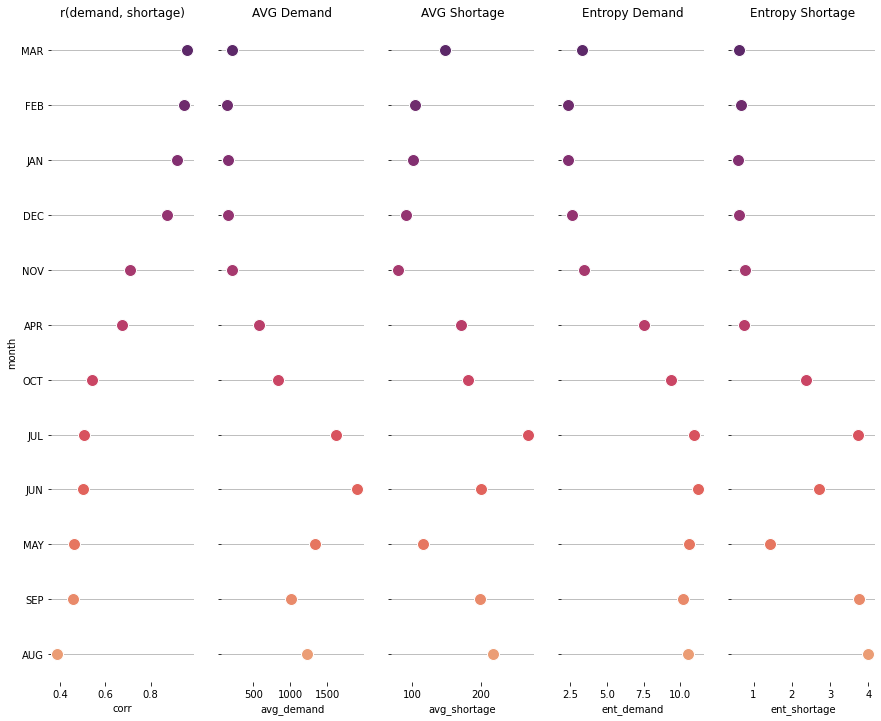

In [22]:
%%time

# Make the PairGrid
g = sns.PairGrid(df.sort_values("corr", ascending=False),
                 x_vars=df.columns[1:], 
                 y_vars=["month"],
                 height=10, 
                 aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=12, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use semantically meaningful titles for the columns
titles = ['r(demand, shortage)', 'AVG Demand', 'AVG Shortage', 'Entropy Demand', 'Entropy Shortage']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


## Example 2.  Multiple time series with SQL filtered values

#### How are demand and storage correlated per month and year for years 1960-1974?  I would like to se how the correlation for each year compares to other year's values.


In [23]:
%%time

sql = f"""
SELECT
    year
    ,month
    ,corr(demand, shortage) as corr
FROM
    '{glob_path}'
GROUP BY
    year
    ,month
;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 197 ms, sys: 65.8 ms, total: 263 ms
Wall time: 263 ms


#### Mixing Pandas filtering with SQL results

CPU times: user 3.59 s, sys: 49.7 ms, total: 3.64 s
Wall time: 3.41 s


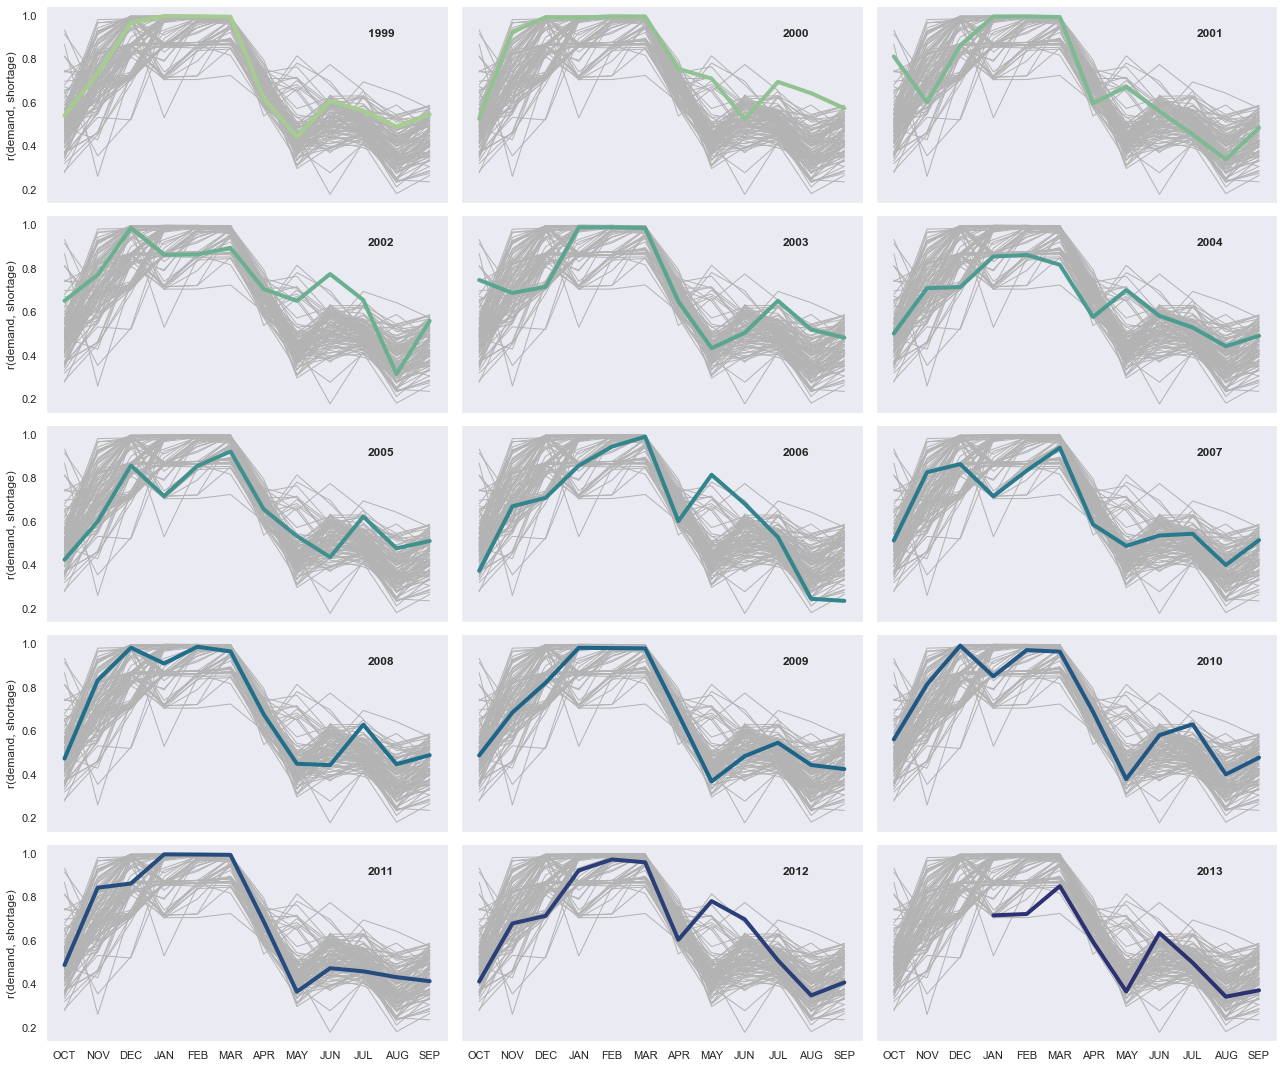

In [24]:
%%time

sns.set_theme(style="dark")

# set order for month as water year
month_order = {'OCT': 1, 'NOV': 2, 'DEC': 3, 'JAN': 4, 'FEB': 5, 'MAR': 6, 'APR': 7, 'MAY': 8, 'JUN': 9, 'JUL': 10, 'AUG': 11, 'SEP': 12}
df['month_id'] = df['month'].map(month_order)

# sort values by year, month
df.sort_values(by=['year', 'month_id'], inplace=True)

# keep only years 2000-2013 for highlighted years
df_slim = df.loc[(df['year'] >= 1999) & (df['year'] <= 2013)]

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_slim,
    x="month", 
    y="corr", 
    col="year", 
    hue="year",
    kind="line", 
    palette="crest", 
    linewidth=4, 
    zorder=5,
    col_wrap=3, 
    height=3, 
    aspect=2, 
    legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df, 
        x="month", 
        y="corr", 
        units="year",
        estimator=None, 
        color=".7", 
        linewidth=1, 
        ax=ax,
    )

# Reduce the frequency of the x axis ticks
# ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "r(demand, shortage)")
g.tight_layout()


## Example 3:  Get data for categorical plotting  

#### What data do I need to explore how shortage varies per realization, adaptive rule, and month?  I am only interested in realizations <= 2.

In [25]:
%%time

sql = f"""
SELECT
    "demand rule" AS demand_rule
    ,shortage
    ,realization
    ,month
FROM
    '{glob_path}'
WHERE
    realization <= 2;
"""

# get query result as a data frame
df = duckdb.query(sql).df()


CPU times: user 357 ms, sys: 157 ms, total: 513 ms
Wall time: 513 ms


#### Plotting the variability in shortage per adaptive rule per month by realization

CPU times: user 1min 7s, sys: 862 ms, total: 1min 7s
Wall time: 1min 7s


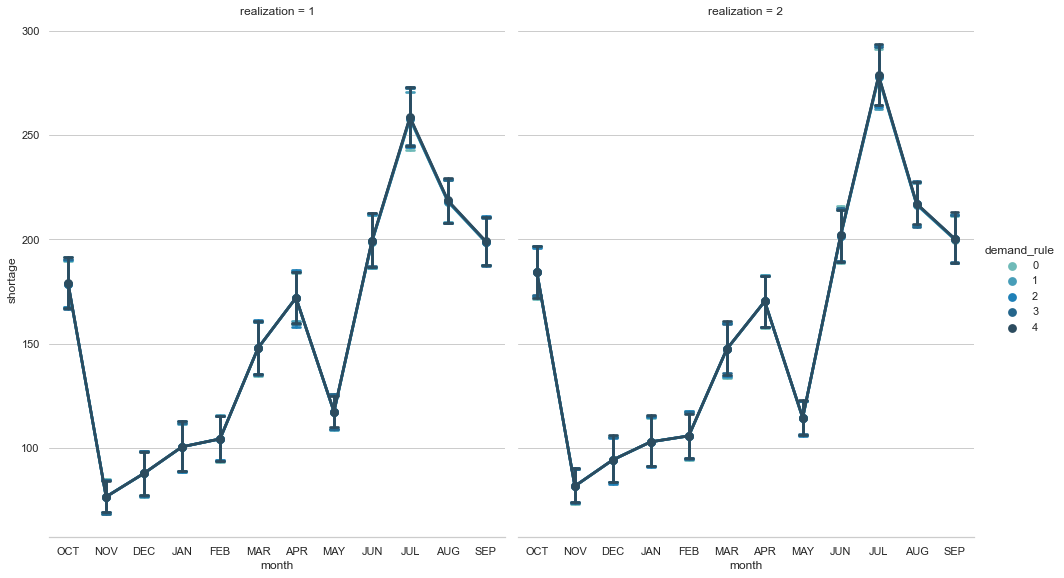

In [23]:
%%time

sns.set_theme(style="whitegrid")

# Draw a pointplot to show shortage as a function of three categorical factors
g = sns.catplot(x="month", 
                y="shortage", 
                hue="demand_rule", 
                col="realization",
                capsize=.2, 
                palette="YlGnBu_d", 
                height=8, 
                aspect=.85,
                kind="point", 
                data=df)

g.despine(left=True)



## Example 4:  Random sampling

#### May I have a random system sample of 10 percent of the data using a fixed seed so that I may reproduce?

In [32]:
%%time

seed = 377
sample_percent = 10

sql = f"""
SELECT
    "demand rule" AS demand_rule
    ,shortage
    ,realization
    ,month
FROM
    '{glob_path}'
USING 
    SAMPLE {sample_percent}% (system, {seed});
"""

# get query result as a data frame
df = duckdb.query(sql).df()

print(f"Here is a selection of {df.shape[0]} rows.")

df.head()


Here is a selection of 329728 rows.
CPU times: user 91.9 ms, sys: 71.7 ms, total: 164 ms
Wall time: 164 ms


,demand_rule,shortage,realization,month
0,0,0,1,FEB
1,0,0,1,MAR
2,0,0,1,APR
3,0,0,1,MAY
4,0,0,1,JUN


#### I would like a reservoir sample of 1000 rows using a fixed seed.

In [33]:
%%time

seed = 100
n_rows_sample = 1000

sql = f"""
SELECT
    "demand rule" AS demand_rule
    ,shortage
    ,realization
    ,month
FROM
    '{glob_path}'
USING 
    SAMPLE reservoir({n_rows_sample} ROWS) REPEATABLE ({seed});
"""

# get query result as a data frame
df = duckdb.query(sql).df()

print(f"Here is a selection of {df.shape[0]} rows.")

df.head()


Here is a selection of 1000 rows.
CPU times: user 66.7 ms, sys: 61 ms, total: 128 ms
Wall time: 128 ms


,demand_rule,shortage,realization,month
0,0,0,2,SEP
1,0,0,2,MAR
2,1,0,2,NOV
3,1,0,2,DEC
4,0,0,1,JAN


#### I would like a random Bernoulli sample of 10 percent of the data.

In [34]:
%%time

sample_percent = 10

sql = f"""
SELECT
    "demand rule" AS demand_rule
    ,shortage
    ,realization
    ,month
FROM
    '{glob_path}'
USING 
    SAMPLE {sample_percent} PERCENT (bernoulli);
"""

# get query result as a data frame
df = duckdb.query(sql).df()

print(f"Here is a selection of {df.shape[0]} rows.")

df.head()


Here is a selection of 345503 rows.
CPU times: user 142 ms, sys: 65.2 ms, total: 207 ms
Wall time: 207 ms


,demand_rule,shortage,realization,month
0,0,0,1,DEC
1,0,0,1,MAR
2,0,0,1,MAR
3,0,0,1,NOV
4,0,0,1,APR


## Advanced cases

#### What is the 3-month moving average of maximum demand per month for each user?

This one uses a subquery to first construct a maximum demand and timestamped date field (`dte`) to query against then uses range framing to calculate a moving average.

In [35]:
%%time

sql = f"""
SELECT
    a.structure_id
    ,a.dte AS date
    ,AVG(a.max_demand) OVER (
        PARTITION BY a.structure_id
        ORDER BY a.dte ASC
        RANGE BETWEEN INTERVAL 1 MONTHS PRECEDING
                  AND INTERVAL 1 MONTHS FOLLOWING)
        AS "3-mth moving AVG of MAX demand"
FROM 
    (
    SELECT
        structure_id
        ,MAX(demand) max_demand
        ,strptime(
            CAST(year AS VARCHAR)
            || '-'
            || CASE month
                WHEN 'OCT' THEN '10'
                WHEN 'NOV' THEN '11'
                WHEN 'DEC' THEN '12'
                WHEN 'JAN' THEN '01'
                WHEN 'FEB' THEN '02'
                WHEN 'MAR' THEN '03'
                WHEN 'APR' THEN '04'
                WHEN 'MAY' THEN '05'
                WHEN 'JUN' THEN '06'
                WHEN 'JUL' THEN '07'
                WHEN 'AUG' THEN '08'
                WHEN 'SEP' THEN '09'
                END
            , '%Y-%m') AS dte
    FROM
        '{glob_path}'
    GROUP BY
        structure_id
        ,dte
    ) AS a
;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

df


CPU times: user 1.4 s, sys: 137 ms, total: 1.54 s
Wall time: 1.54 s


,structure_id,date,3-mth moving AVG of MAX demand
0,4500685,1908-10-01,58.500000
1,4500685,1908-11-01,42.000000
2,4500685,1908-12-01,5.333333
3,4500685,1909-01-01,7.666667
4,4500685,1909-02-01,10.000000
...,...,...,...
432175,3900638,2013-05-01,113.333333
432176,3900638,2013-06-01,188.000000
432177,3900638,2013-07-01,204.333333
432178,3900638,2013-08-01,149.333333
